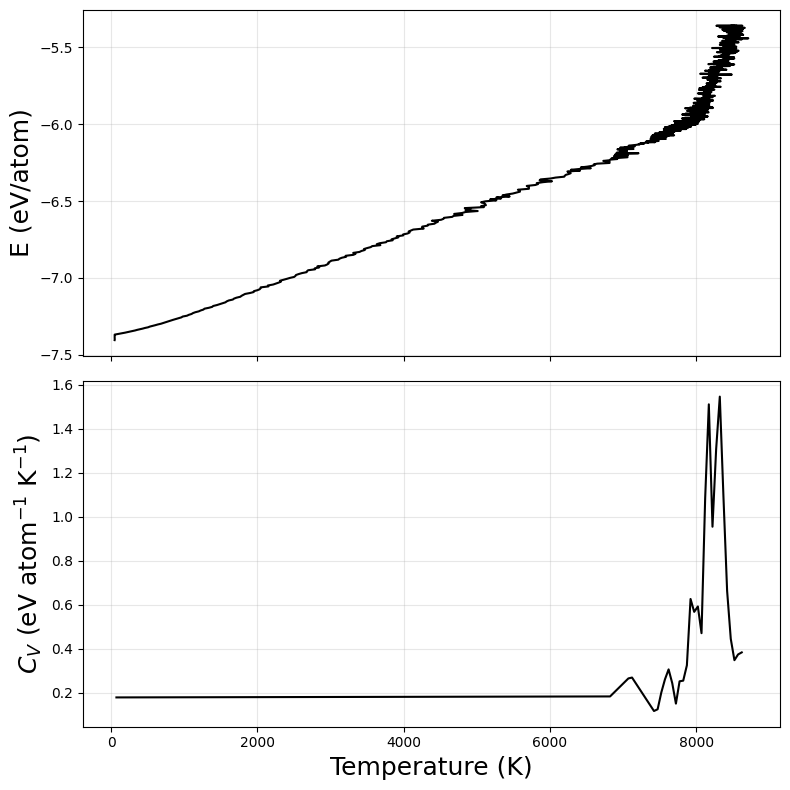

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ---- user-editable parameters --------------------------------------------
FNAME    = 'data/e_vs_t.txt'  # path to your text file
N_ATOMS  = 11040             # number of atoms
BIN_SIZE = 50              # temperature bin width in K
# --------------------------------------------------------------------------

def load_e_vs_t(fname):
    """
    Read temperature and total energy per atom from a text file.
    """
    # columns: timestep, temp, total_energy, kinetic, potential
    raw = np.loadtxt(fname, usecols=(1, 2),skiprows=1)
    T_all = raw[:, 0]
    E_all = raw[:, 1] / N_ATOMS
    return T_all, E_all

# 1) load data
T, E = load_e_vs_t(FNAME)

# 2) smooth energy for display
E_smooth = gaussian_filter1d(E, sigma=20)

# 3) binning for C_V
bins = np.arange(T.min(), T.max() + BIN_SIZE, BIN_SIZE)
bin_idx = np.digitize(T, bins)

T_mid = []
E_mean = []
for b in range(1, len(bins)):
    sel = bin_idx == b
    if sel.sum() > 5:
        T_mid.append(bins[b-1] + BIN_SIZE/2)
        E_mean.append(E[sel].mean())
T_mid  = np.array(T_mid)
E_mean = np.array(E_mean)

# 4) derivative = C_V
Cv_binned = np.gradient(E_mean, T_mid)  # eV/atom/K

# 5) plot subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top: Energy vs T
ax1.plot(T, E_smooth, c='k')
ax1.set_ylabel('E (eV/atom)', fontsize=18)
ax1.grid(alpha=0.3)

# Bottom: Heat capacity
ax2.plot(T_mid, Cv_binned * 1e3, c='k', markersize=5)
ax2.set_xlabel('Temperature (K)', fontsize=18)
ax2.set_ylabel(r'$C_V$ (eV atom$^{-1}$ K$^{-1}$)', fontsize=18)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [3]:
np.set_printoptions(suppress=True, precision=3)
kB = 8.617*10e-5

raw = np.loadtxt("data/e_vs_t.txt")

pe_50 = np.mean(raw[:,-1][0:25])
T_50 = np.mean(raw[:,1][0:25])

Gamma_50 = pe_50/(kB*T_50)
Gamma_50

-171.38284192073417

In [23]:
import numpy as np
# Constants
kB = 8.617*10**(-5)  # eV/K in metal units
interval = 10000  # fix stats print interval
window = 10       # number of frames to average

# Mapping: temp -> line range (adjustable)
stages = {
    50:   (0, 25),
    7000: (225, 235),
    7500: (285, 310),
    7750: (410, 460),
    8000: (560, 610),
    8250: (710, 735),
    8500: (835, 845),
    8750: (945, 955)
}

# Load energy.txt
data = np.loadtxt("data/e_vs_t.txt",skiprows=1)

# Extract and calculate Gamma
gammas = {}
for T_target, (start, end) in stages.items():
    T_vals = data[start:end, 1]
    PE_vals = data[start:end, -1]
    
    T_avg = np.mean(T_vals)
    PE_avg = np.mean(PE_vals)
    Gamma = np.abs(PE_avg) / (kB * T_avg)
    gammas[T_target] = Gamma

# Display results
print("Gamma values by temperature:")
for T, G in sorted(gammas.items()):
    print(f"{T} K: Γ ≈ {G:.3f}")

Gamma values by temperature:
50 K: Γ ≈ 1713.828
7000 K: Γ ≈ 11.200
7500 K: Γ ≈ 10.420
7750 K: Γ ≈ 10.017
8000 K: Γ ≈ 9.601
8250 K: Γ ≈ 9.023
8500 K: Γ ≈ 8.494
8750 K: Γ ≈ 8.307


In [3]:
import numpy as np

# Constants
kB = 8.617*10**(-5)  # eV/K in metal units
interval = 10000
window = 10  # number of frames to average

# New stage mapping
stages = {
    50:    (0, 25),
    7000:  (75, 85),
    8100:  (195, 205),
    8200:  (305, 315),
    8300:  (415, 425),
}

# Load energy data
data = np.loadtxt("data/e_vs_t2.txt")  # columns: step T Etot KE PEatom

# Calculate Gamma for each stage
gammas = {}
for T, (start, end) in stages.items():
    T_vals = data[start:end, 1]        # temperature column
    PE_vals = data[start:end, -1]      # potential energy per atom column

    T_avg = np.mean(T_vals)
    print(T_avg)
    PE_avg = np.mean(PE_vals)
    Gamma = np.abs(PE_avg) / (kB * T_avg)
    gammas[T] = Gamma

# Print results
print("Gamma values during hold periods:")
for T, G in sorted(gammas.items()):
    print(f"{T} K: Γ ≈ {G:.3f}")


50.24036963341414
6984.7432097042765
8079.379745770442
8207.897339580071
8312.81636757915
Gamma values during hold periods:
50 K: Γ ≈ 1713.828
7000 K: Γ ≈ 11.265
8100 K: Γ ≈ 9.555
8200 K: Γ ≈ 9.203
8300 K: Γ ≈ 8.787


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, distance_matrix
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def NN(positions, cutoff):
    """
    Nearest neighbours via cKDTree radius search.
    Returns a list of neighbor‐index lists for each atom.
    """
    tree = cKDTree(positions)
    # query_ball_tree returns for each i the list of all j within cutoff (including i)
    raw = tree.query_ball_tree(tree, cutoff)
    # remove self from each list
    neighbor_list = [
        [j for j in neigh if j != i]
        for i, neigh in enumerate(raw)
    ]
    return neighbor_list

def theta_ij(xi, yi, xj, yj):
    dx = xj - xi
    dy = yj - yi
    return np.arctan2(dy,dx)

# --- Helper function: simple ring-finding based on DFS ---
def find_rings(adjacency, max_cycle_size=8):
    """
    Find all simple cycles (rings) in an undirected graph represented by an adjacency list.
    Returns a set of frozensets, each representing a ring (order is disregarded).
    """
    N = len(adjacency)
    found_rings = set()

    def dfs(start, current_path, visited_set):
        if len(current_path) > max_cycle_size:
            return
        current = current_path[-1]
        for nbr in adjacency[current]:
            if nbr == start and len(current_path) >= 3:
                # Found a cycle: sort the path to create a canonical representation
                ring = frozenset(current_path)
                found_rings.add(ring)
            elif nbr not in visited_set:
                dfs(start, current_path + [nbr], visited_set | {nbr})

    for i in range(N):
        dfs(i, [i], {i})
    return found_rings

# --- Helper function: reorder a ring into a cyclic path ---
def reorder_ring(ring_nodes, positions):
    """
    Given a set or list of nodes that form a cycle, return a list of nodes
    ordered such that consecutive nodes are (approximately) neighbors in space.
    A simple greedy approach is used.
    """
    ring_nodes = list(ring_nodes)
    if len(ring_nodes) < 3:
        return ring_nodes
    # Start with the leftmost node
    ring_nodes.sort(key=lambda i: (positions[i, 0], positions[i, 1]))
    ordered = [ring_nodes[0]]
    used = set(ordered)
    while len(ordered) < len(ring_nodes):
        last = ordered[-1]
        # Choose the remaining node closest to the last one.
        next_node = min([i for i in ring_nodes if i not in used],
                        key=lambda i: np.linalg.norm(positions[i]-positions[last]))
        ordered.append(next_node)
        used.add(next_node)
    return ordered

def plot_lattice(positions, random_atom, random_index, neighbor_list, neighbor_indices, zoom, atom_numbers, fname="picture"):
    N = len(positions)
    neighbor_count = np.array([len(nlist) if isinstance(nlist, list) else 1 for nlist in neighbor_list])


    edges = []
    for i in range(N):
        neighs = neighbor_list[i] if isinstance(neighbor_list[i], list) else [neighbor_list[i]]
        for j in neighs:
            if j > i:
                edges.append((i, j))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    pos_x = positions[:, 0]
    pos_y = positions[:, 1]
    #ax.scatter(pos_x, pos_y, s=10, c='k')
    
    """
    if zoom == True:
        for (i, j) in edges:
            xi, yi = positions[i]
            xj, yj = positions[j]
            ax.plot([xi, xj], [yi, yj], 'k-', linewidth=0.5, alpha=0.7)
        
        pos_x = positions[:, 0]
        pos_y = positions[:, 1]
        ax.scatter(pos_x, pos_y, c=color_array, s=30, label='Atoms')

        ax.scatter(random_atom[0], random_atom[1], color='red', s=100,
                label=f'Atom {atom_numbers[random_index]} (Chosen)')
        if neighbor_indices:
            ax.scatter(positions[neighbor_indices, 0], positions[neighbor_indices, 1],
                    color='blue', s=60, label='Nearest Neighbors')
        
        ax.text(random_atom[0], random_atom[1], f'{atom_numbers[random_index]}',
                color='red', fontsize=12, ha='right', va='top')
    """

    ax.set_xlabel('x (Å)')
    ax.set_ylabel('y (Å)')
    ax.grid(True)
    ax.axis('equal')
    rings = find_rings(neighbor_list, max_cycle_size=8)
    
    for ring in rings:
        if len(ring) == 6:
            ordered = reorder_ring(ring, positions)
            coords = positions[ordered + [ordered[0]]]
            ax.plot(coords[:,0], coords[:,1],
                    '-', color='green', linewidth=1.5, zorder=1)

    for ring in rings:
        if len(ring) in (5, 7, 8):
            ordered = reorder_ring(ring, positions)
            coords = positions[ordered + [ordered[0]]]
            ax.plot(coords[:,0], coords[:,1], '-', color='red', linewidth=2, zorder=10)
        
        
    # 6) Inset for zoomed-in bond-angle view for the chosen atom and its neighbors.
    inset_size = 0.35
    if zoom == True:
        axins = inset_axes(ax, width=f"{int(inset_size*100)}%", height=f"{int(inset_size*100)}%",
                        loc='upper right', borderpad=2)

        # In the inset, plot the background (all atoms as light gray)
        axins.scatter(pos_x, pos_y, c='black', s=10)
        axins.scatter(random_atom[0], random_atom[1], color='red', s=100)
        axins.scatter(positions[neighbor_indices, 0], positions[neighbor_indices, 1],
                    color='blue', s=60)

        # Draw green dashed lines from the chosen atom to each neighbor in inset
        angles = []
        for j in neighbor_indices:
            xj, yj = positions[j]
            theta = theta_ij(random_atom[0], random_atom[1], xj, yj)
            angles.append(theta)
            
            axins.plot([random_atom[0], xj], [random_atom[1], yj], 'g--', linewidth=1)
            angle_deg = np.degrees(theta)
            mid_x = (random_atom[0] + xj) / 2
            mid_y = (random_atom[1] + yj) / 2
            axins.text(mid_x, mid_y, f"{angle_deg:.1f}°", fontsize=8,
                    color='black', ha='center', va='center')
        
        padding = 2.0
        axins.set_xlim(random_atom[0] - padding, random_atom[0] + padding)
        axins.set_ylim(random_atom[1] - padding, random_atom[1] + padding)
        axins.set_xticks([])
        axins.set_yticks([])
        axins.set_title(r"Director field $\theta_{ij}$", fontsize=12)
    plt.savefig(f'../output/{fname}.pdf') 
    plt.show()